# Практическое задание №6 по теме "Задача lookalike (Positive Unlabeled Learning)".

1. Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. Сделать feature engineering (под вопросом)
4. Обучить любой классификатор (какой вам нравится)
5. Разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. Применить random negative sampling для построения классификатора в новых условиях
7. Сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. Поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# словарь для записи результатов 
results = {}

## Задание №1

Возьмем датасет из урока по оттоку (клиенты банка).<br>
1 - человек пошел в отток<br>
0 - человек остается с нами

In [3]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [4]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Задание №2

Составим списки и избавимся от RowNumber, CustomerId, Surname. 

In [6]:
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
cat_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
target = ['Exited']

In [7]:
df = df[num_features+cat_features+target]
df.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography,Gender,HasCrCard,IsActiveMember,Exited
0,619,42,2,0.00,1,101348.88,France,Female,1,1,1
1,608,41,1,83807.86,1,112542.58,Spain,Female,0,1,0
2,502,42,8,159660.80,3,113931.57,France,Female,1,0,1


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, df[target], random_state=12)

In [9]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

# перевод категориального признака в бинарное представление
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [10]:
def print_pu_metrics(pu_metrics, pu_learning_perc_dict):
    plt.figure(figsize=(14, 8))
    x = np.fromiter(pu_learning_perc_dict.values(), dtype=float)*100
    y1 = pu_metrics['f-score']
    y2 = pu_metrics['recall'] 
    y3 = pu_metrics['precision']
    plt.plot(x, y1, label='f-score')
    plt.plot(x, y2, label='recall')
    plt.plot(x, y3, label='precision')
    plt.title("Графики зависимостей показателей метрик от доли позитивных ответов P")
    plt.xlabel("Доля позитивных ответов P, %")
    plt.ylabel("Значение метрик, [0, 1]", )
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
final_transformers = list()

for cat_col in cat_features:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in num_features:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [12]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

## Задание №3

Обучим классификатор "Случайный лес".

In [13]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [14]:
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

In [15]:
f1 = f1_score(y_test, preds)
print("f1: %.2f%%" % (f1 * 100.0))
roc = roc_auc_score(y_test, preds)
print("roc: %.2f%%" % (roc * 100.0)) 
recall = recall_score(y_test, preds, average='binary')
print("recall: %.2f%%" % (recall * 100.0)) 
precision = precision_score(y_test, preds, average='binary')
print("precision: %.2f%%" % (precision * 100.0)) 

f1: 59.22%
roc: 71.70%
recall: 46.22%
precision: 82.37%


In [16]:
results['RandomForest'] = [f1, roc, recall, precision]

## Задание №4, 5

Теперь очередь за **PU Learning**. Заранее сделаем PU Learning с разными долями P (это нужно для дальнейших заданий).

In [17]:
pu_learning_perc = {'PU_10':0.1, 'PU_15':0.15, 'PU_20':0.2, 'PU_25':0.25, 'PU_30':0.3, 'PU_40':0.4, 'PU_50':0.5, 'PU_75':0.75}

In [18]:
# Разбиваем данные на P и U.
for approach, pos_perc in pu_learning_perc.items():
    print(f"PU Learning {pos_perc*100}%")
    
    #Представим, что нам неизвестны негативы и часть позитивов.
    mod_data = df.copy()
    pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
    np.random.shuffle(pos_ind)
    pos_sample_len = int(np.ceil(pos_perc * len(pos_ind)))
    print(f"\t\tUsing {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest.")
    pos_sample = pos_ind[:pos_sample_len]

    # делаем новый таргентный столбец
    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1

    # использщуем random negative sampling
    mod_data = mod_data.sample(frac=1)
    data_U = mod_data[mod_data['class_test']==-1]
    data_P = mod_data[mod_data['class_test']==1]
    neg_sample = data_U[:data_P.shape[0]] # чтоб сбалансированная выборка была
    sample_test = data_U[data_P.shape[0]:]
    pos_sample = data_P.copy()
    print(f"\t\tNeg: {neg_sample.shape}, Pos: {pos_sample.shape}")
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
    print(f"\t\tTrain: {sample_train.shape}, Test: {sample_test.shape}")
    
    # обучение модели
    pipeline = Pipeline([
        ('features',feats),
        ('classifier', RandomForestClassifier(random_state = 42)),
    ])
    pipeline.fit(sample_train.iloc[:,:-2], 
                 sample_train.iloc[:,-2])
    preds = pipeline.predict(sample_test.iloc[:,:-2])

    # оценка
    f1 = f1_score(sample_test.iloc[:,-2].values, preds)
    roc = roc_auc_score(sample_test.iloc[:,-2].values, preds)
    recall = recall_score(sample_test.iloc[:,-2].values, preds, average='binary') 
    precision = precision_score(sample_test.iloc[:,-2].values, preds, average='binary')
    
    # запись в словарь
    results[approach] = [f1, roc, recall, precision]

PU Learning 10.0%
		Using 204/2037 as positives and unlabeling the rest.
		Neg: (204, 12), Pos: (204, 12)
		Train: (408, 12), Test: (9592, 12)
PU Learning 15.0%
		Using 306/2037 as positives and unlabeling the rest.
		Neg: (306, 12), Pos: (306, 12)
		Train: (612, 12), Test: (9388, 12)
PU Learning 20.0%
		Using 408/2037 as positives and unlabeling the rest.
		Neg: (408, 12), Pos: (408, 12)
		Train: (816, 12), Test: (9184, 12)
PU Learning 25.0%
		Using 510/2037 as positives and unlabeling the rest.
		Neg: (510, 12), Pos: (510, 12)
		Train: (1020, 12), Test: (8980, 12)
PU Learning 30.0%
		Using 612/2037 as positives and unlabeling the rest.
		Neg: (612, 12), Pos: (612, 12)
		Train: (1224, 12), Test: (8776, 12)
PU Learning 40.0%
		Using 815/2037 as positives and unlabeling the rest.
		Neg: (815, 12), Pos: (815, 12)
		Train: (1630, 12), Test: (8370, 12)
PU Learning 50.0%
		Using 1019/2037 as positives and unlabeling the rest.
		Neg: (1019, 12), Pos: (1019, 12)
		Train: (2038, 12), Test: (79

## Задание №6, 7

In [19]:
df = pd.DataFrame(results, index=['f-score','roc', 'recall', 'precision']).T
df

,f-score,roc,recall,precision
RandomForest,0.592166,0.716969,0.462230,0.823718
PU_10,0.492266,0.733683,0.805787,0.354381
PU_15,0.486506,0.743346,0.826243,0.344750
PU_20,0.467800,0.738990,0.828846,0.325857
PU_25,0.476388,0.749978,0.796399,0.339835
PU_30,0.463387,0.748369,0.781532,0.329326
PU_40,0.425025,0.736249,0.746441,0.297096
PU_50,0.404972,0.766139,0.813541,0.269584
PU_75,0.273911,0.749601,0.729665,0.168601


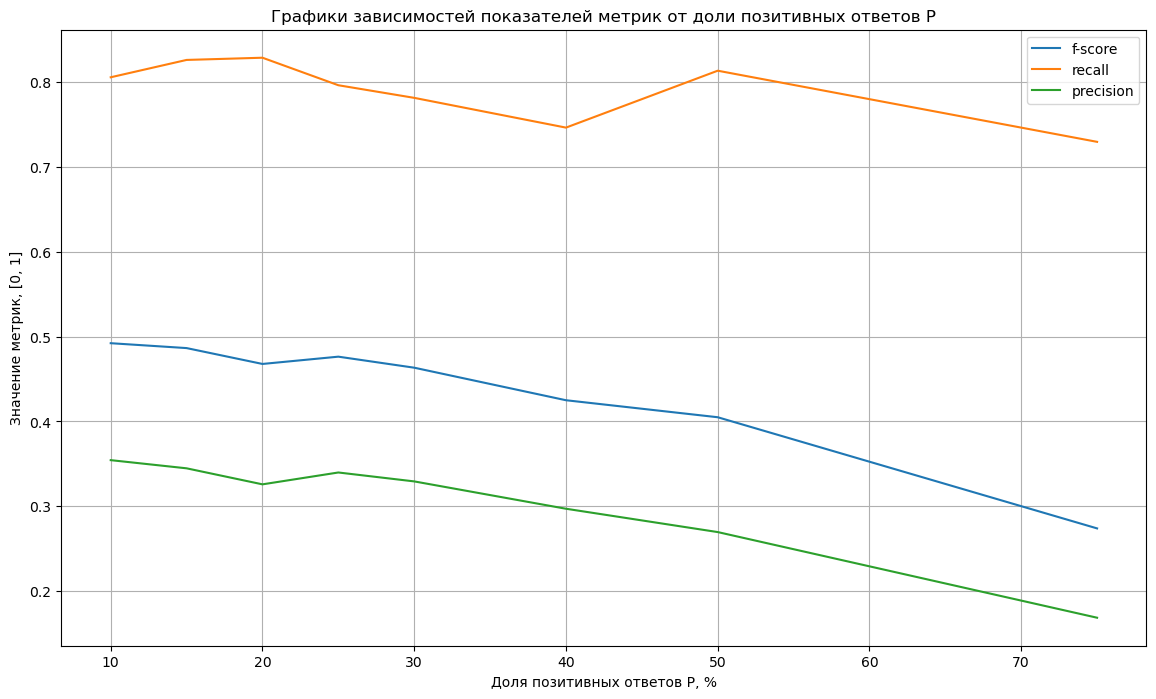

In [20]:
print_pu_metrics(df[1:], pu_learning_perc)

**Вывод:**

Как видно по результирующей табилце, обычный классификатор RandomForest показывает лучшие результаты по сравнению со всеми вариантами PU Learning, за исключением показателя *Recall*. Это подтверждает логичный факт, что классический Supervised Learning на размеченных данных лучше, чем PU Learning на частично-размеченных данных.

Если по данной таблице анализировать результаты PU Learning с разной долей $P$ ответов, то можно сказать, что при увеличении доли $P$ качество модели становилось хуже.

---